In [20]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
import openai
import matplotlib.pyplot as plt
import seaborn as sns
import mlrose_hiive as mlrose

In [21]:
# Set your OpenAI API key
openai.api_key = ''

In [22]:
# Step 1: Load the dataset
file_path = '3026NMfixed_UT.csv'
dataset = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(dataset.head())

   Speaker                       utterance  ut
0        2                      Nope. No.   10
1        2                       Yes. No.   10
2        2                          Yeah.   10
3        2                      Movement.    9
4        2  Distance traveling over time.    9


In [23]:
# Function to get GPT-3 embeddings for a given text
def get_gpt3_embeddings(text_list, batch_size=10):
    embeddings = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]
        response = openai.Embedding.create(model="text-embedding-ada-002", input=batch)
        embeddings.extend([res['embedding'] for res in response['data']])
    return np.array(embeddings)

In [24]:
# Get GPT-3 embeddings for the 'utterance' column
X_text = get_gpt3_embeddings(dataset['utterance'].tolist())

In [25]:
# Step 3: Dimensionality Reduction (Optional but can help with noise)
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X_text)

In [26]:
# Step 4: Define the Optimization Problem for MIMIC
def evaluate_clusters(state):
    k = int(state[0])
    if k < 2:
        return -1
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_reduced)
    score = silhouette_score(X_reduced, labels)
    return score

In [27]:
# Define the optimization problem
problem = mlrose.DiscreteOpt(length=1, fitness_fn=mlrose.CustomFitness(evaluate_clusters), maximize=True, max_val=31)

In [28]:
# Step 5: Run the MIMIC Algorithm with adjusted parameters
best_state, best_fitness, fitness_curve = mlrose.mimic(problem, pop_size=300, keep_pct=0.3, max_attempts=20, max_iters=200, curve=True, random_state=42)

optimal_k_mimic = int(best_state[0])
optimal_score_mimic = best_fitness

print(f"MIMIC - Optimal number of clusters: {optimal_k_mimic}")
print(f"MIMIC - Best silhouette score: {optimal_score_mimic}")

MIMIC - Optimal number of clusters: 28
MIMIC - Best silhouette score: 0.145640612350527


In [29]:
# Perform final clustering with the optimal number of clusters from MIMIC
kmeans_mimic = KMeans(n_clusters=optimal_k_mimic, random_state=42, n_init=10)
final_labels_mimic = kmeans_mimic.fit_predict(X_reduced)

In [30]:
# Display the cluster labels for the first few utterances
dataset['Cluster_MIMIC'] = final_labels_mimic
print(dataset.head())

   Speaker                       utterance  ut  Cluster_MIMIC
0        2                      Nope. No.   10              3
1        2                       Yes. No.   10              3
2        2                          Yeah.   10             20
3        2                      Movement.    9             25
4        2  Distance traveling over time.    9             15


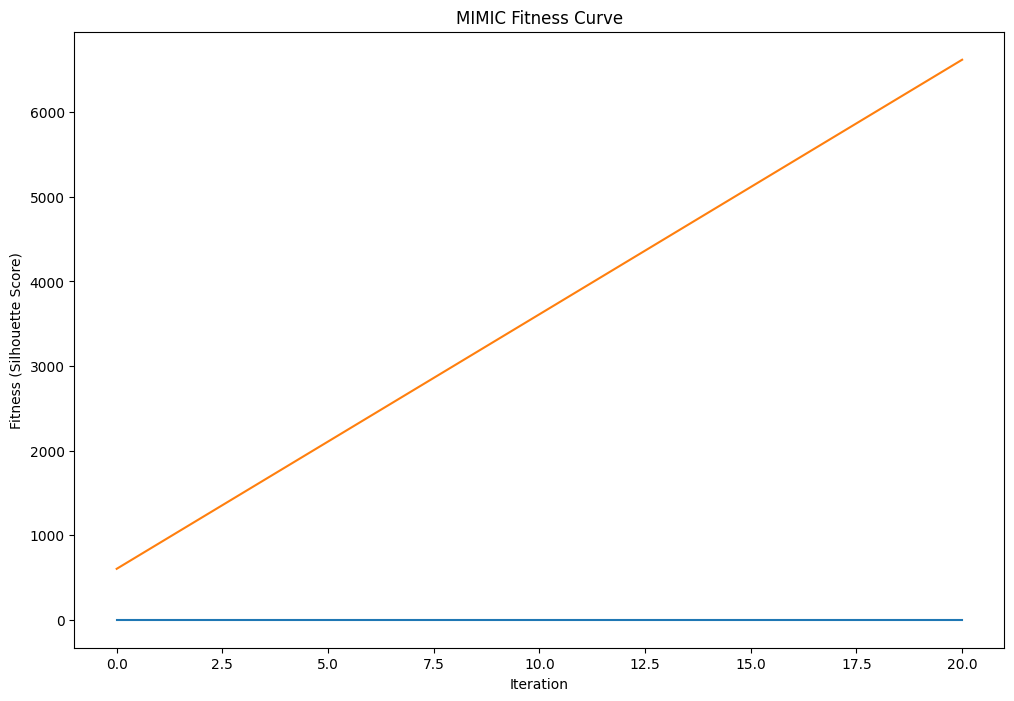

In [31]:
# Visualization Step 1: Fitness Curve
plt.figure(figsize=(12, 8))
plt.plot(fitness_curve)
plt.xlabel('Iteration')
plt.ylabel('Fitness (Silhouette Score)')
plt.title('MIMIC Fitness Curve')
plt.show()

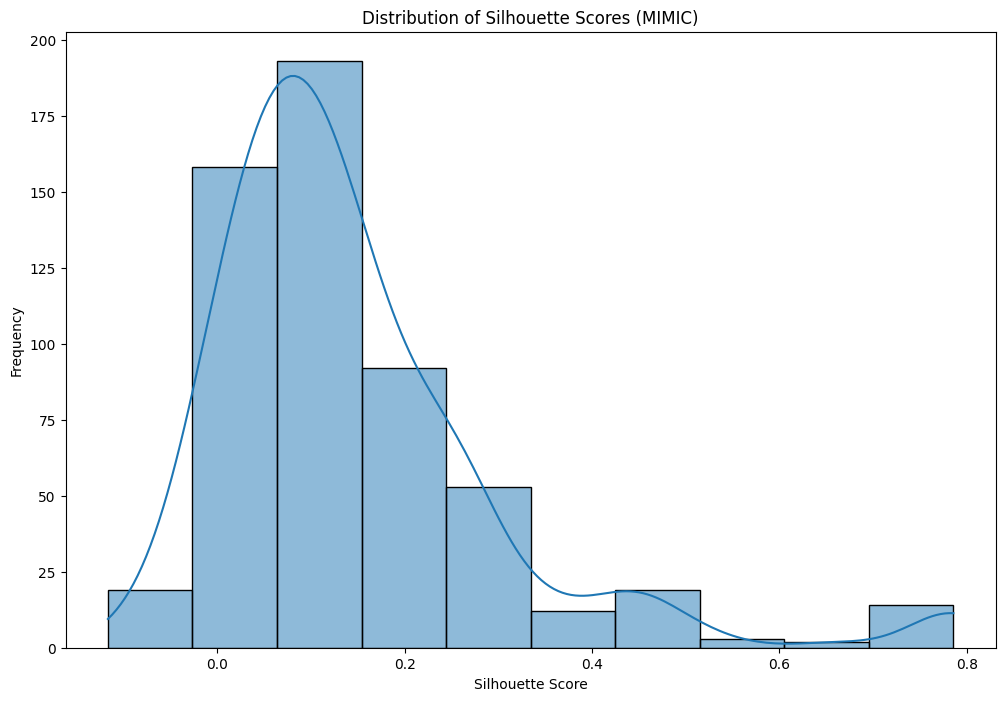

In [32]:
# Visualization Step 3: Histogram of Silhouette Scores
sample_silhouette_values = silhouette_samples(X_reduced, final_labels_mimic)

plt.figure(figsize=(12, 8))
sns.histplot(sample_silhouette_values, bins=10, kde=True)
plt.xlabel('Silhouette Score')
plt.ylabel('Frequency')
plt.title('Distribution of Silhouette Scores (MIMIC)')
plt.show()

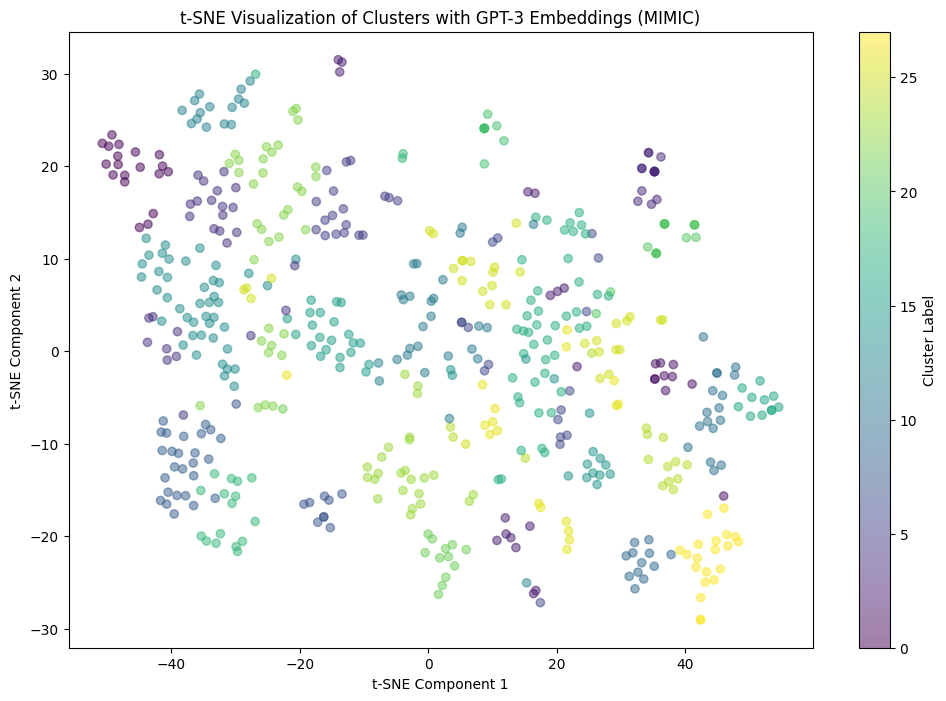

In [33]:
# Plot the clusters from MIMIC
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=final_labels_mimic, cmap='viridis', alpha=0.5)
plt.title('t-SNE Visualization of Clusters with GPT-3 Embeddings (MIMIC)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

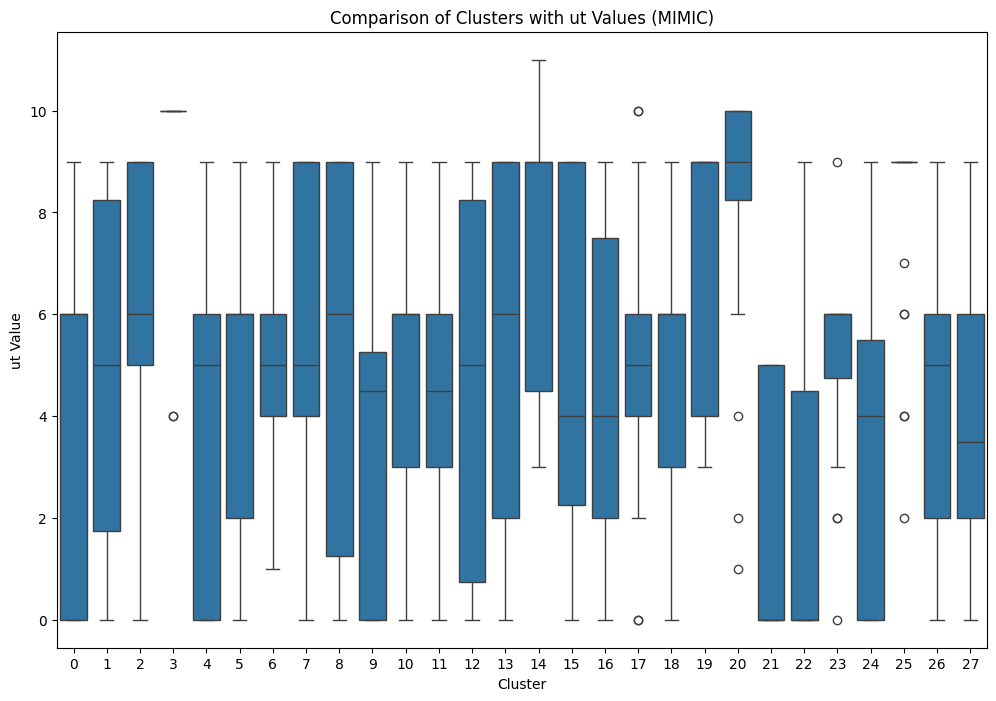

In [34]:
# Step 7: Compare Clusters with 'ut' Values for MIMIC

# Box plot to visualize the distribution of 'ut' values across clusters for MIMIC
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cluster_MIMIC', y='ut', data=dataset)
plt.title('Comparison of Clusters with ut Values (MIMIC)')
plt.xlabel('Cluster')
plt.ylabel('ut Value')
plt.show()

In [35]:
# Statistical summary of 'ut' values in each cluster for MIMIC
cluster_summary_mimic = dataset.groupby('Cluster_MIMIC')['ut'].describe()
print(cluster_summary_mimic)

               count      mean       std  min    25%   50%    75%   max
Cluster_MIMIC                                                          
0               19.0  4.315789  3.496866  0.0   0.00   6.0   6.00   9.0
1               10.0  4.800000  3.614784  0.0   1.75   5.0   8.25   9.0
2               17.0  6.000000  3.000000  0.0   5.00   6.0   9.00   9.0
3               14.0  9.142857  2.178819  4.0  10.00  10.0  10.00  10.0
4               27.0  3.555556  2.886751  0.0   0.00   5.0   6.00   9.0
5               18.0  4.666667  2.700762  0.0   2.00   6.0   6.00   9.0
6               17.0  5.294118  2.519045  1.0   4.00   5.0   6.00   9.0
7               10.0  5.500000  3.439961  0.0   4.00   5.0   9.00   9.0
8               26.0  4.807692  3.589086  0.0   1.25   6.0   9.00   9.0
9               12.0  3.583333  2.998737  0.0   0.00   4.5   5.25   9.0
10              17.0  4.764706  3.031695  0.0   3.00   6.0   6.00   9.0
11              24.0  4.041667  2.561914  0.0   3.00   4.5   6.0

In [36]:
# Additional Performance Metrics
calinski_harabasz = calinski_harabasz_score(X_reduced, final_labels_mimic)
davies_bouldin = davies_bouldin_score(X_reduced, final_labels_mimic)

print(f"MIMIC - Calinski-Harabasz Score: {calinski_harabasz}")
print(f"MIMIC - Davies-Bouldin Score: {davies_bouldin}")

MIMIC - Calinski-Harabasz Score: 18.327848050515854
MIMIC - Davies-Bouldin Score: 2.0443476791511572


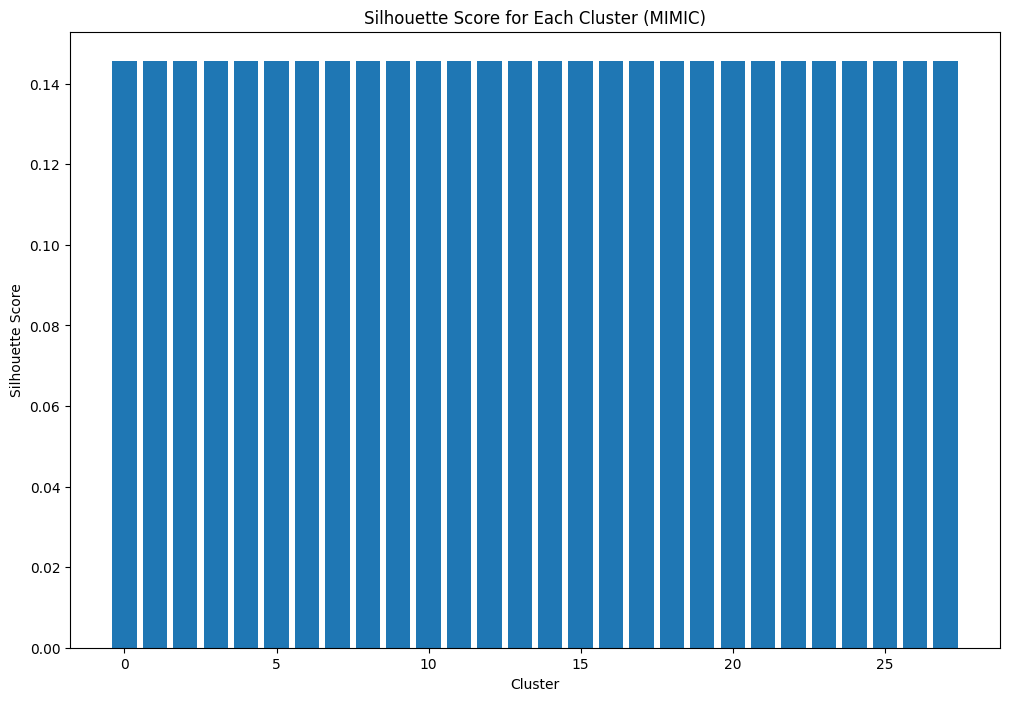

In [37]:
# Visualization Step 2: Bar Plot of Silhouette Score for each Cluster
silhouette_values = silhouette_score(X_reduced, final_labels_mimic)
plt.figure(figsize=(12, 8))
plt.bar(range(optimal_k_mimic), silhouette_values)
plt.xlabel('Cluster')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Each Cluster (MIMIC)')
plt.show()